# 🏦 Loan Default Prediction - Modelling

In this notebook, we'll prepare

At the end of this notebook we will

# 📚 1. Import Libraries

In [24]:
# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
# Display only 3 digits after floating point in pandas objects
pd.set_option('display.float_format', lambda x:'%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
# Configure default settings for plots
sb.set(style='ticks')
sb.set_palette('Paired')
plt.rcParams['axes.spines.top'] = False     # Remove top border
plt.rcParams['axes.spines.right'] = False   # Remove righr border

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
# Data Processing Librariies
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## Algorithms
# Ensemble Methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Non-linear Methods
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Linear Methods
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Performance Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Save model
import pickle

import warnings
warnings.simplefilter(action="ignore", category=Warning)

# 📖 2. Load Data

## 2.1. Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Colab Notebooks/Capstone-Project-Loan-Default-Prediction/Data/Processed/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Capstone-Project-Loan-Default-Prediction/Data/Processed


In [3]:
!ls

hmeq_knn_imputed.csv	     hmeq_no_debtinc_no_null_no_outliers.csv
hmeq_no_debtinc_no_null.csv  hmeq_no_null.csv


✍🏼 **Note:** As you can see we have 4 different datasets. We'll start modelling with the one that we think is the best.

In [4]:
%cd ..
%cd ..

/content/drive/My Drive/Colab Notebooks/Capstone-Project-Loan-Default-Prediction/Data
/content/drive/My Drive/Colab Notebooks/Capstone-Project-Loan-Default-Prediction


In [5]:
!ls

Data  Images  License.md  Models  Notebooks  README.md


In [6]:
# Set directorty paths as global variable
data_path = './Data/Processed/'

raw_data = pd.read_csv(data_path + 'hmeq_no_debtinc_no_null_no_outliers.csv')
print(f'The dataset has {raw_data.shape[0]} rows and {raw_data.shape[1]} columns')

# Create a copy of the dataframe to secure it against changes
df = raw_data.copy()
df.head()

The dataset has 4222 rows and 12 columns


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO
0,1,1100,25860.000,39025.000,HomeImp,Other,10.500,0.000,0.000,94.367,1.000,9.000
1,1,1300,70053.000,68400.000,HomeImp,Other,7.000,0.000,2.000,121.833,0.000,14.000
2,1,1500,13500.000,16700.000,HomeImp,Other,4.000,0.000,0.000,149.467,1.000,10.000
3,0,1700,97800.000,112000.000,HomeImp,Office,3.000,0.000,0.000,93.333,0.000,14.000
4,1,1700,30548.000,40320.000,HomeImp,Other,9.000,0.000,0.000,101.466,1.000,8.000


# 🔂 3. Transform Data

In [7]:
def transform_data(df, target, num_features, cat_features, name=''):
    # Encoding target
    lbl_encoder = LabelEncoder()
    df[target+'_Encoded'] = lbl_encoder.fit_transform(df[target])
    df[target+'_Encoded'].value_counts()

    # Assign features and labels
    x = df.drop([target, target+'_Encoded'], axis=1)
    y = df[target+'_Encoded']

    # Split the dataset into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

    # Standardization and Encoding
    # Define transformers for different column types
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

    # Combine transformers for specific columns
    preprocessor = ColumnTransformer([
        ("num", numerical_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ])

    # Fit transformers on training data only
    preprocessor.fit(x_train)

    # Transform train and test data using fitted transformers
    x_train_transformed = preprocessor.transform(x_train)
    x_test_transformed = preprocessor.transform(x_test)

    # Save the preprocessor
    processor_name = f'./Models/data_preprocessor_{name}.pkl'
    with open(processor_name, 'wb') as preprocessor_file:
        pickle.dump(preprocessor, preprocessor_file)

    return x_train_transformed, x_test_transformed, y_train, y_test

In [8]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)

print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

Categorical columns: 2 ['REASON', 'JOB']
Numeric columns: 10 ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO']


In [9]:
target = 'BAD'
num_cols.remove('BAD')

In [10]:
# We'll give name of ndnlno which stands for no_debtinc_no_null_no_outliers
x_train, x_test, y_train, y_test = transform_data(df, target, num_cols, cat_cols, 'ndnlno')
print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (3377, 15)
x_test: (845, 15)


# 🧱 4. Model Building

## 4.1. Comparing Different Algorithms

In this section we'll compare non-linear and ensemble algorithms using k-fold cross validation.

❗️ We'll prioritizing the **maximization of Recall** over Precision and Accuracy is crucial for risk mitigation.

In [36]:
def plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages):
    stages_shape = np.linspace(100, x_train.shape[0], num_stages, dtype=int)
    ACC = []
    PREC = []
    REC = []
    F1 = []

    for stage in stages_shape:
        X_train_temp = x_train[:stage]
        y_train_temp = y_train[:stage]
        model.fit(X_train_temp, y_train_temp)
        prediction_test = model.predict(x_test)

        acc = accuracy_score(y_test, prediction_test)
        prec = precision_score(y_test, prediction_test)
        rec = recall_score(y_test, prediction_test)
        f1 = f1_score(y_test, prediction_test)

        ACC.append(acc)
        PREC.append(prec)
        REC.append(rec)
        F1.append(f1)

    plt.figure(figsize=(8, 4))
    plt.plot(stages_shape, ACC, label='Accuracy')
    plt.plot(stages_shape, PREC, label='Precision')
    plt.plot(stages_shape, REC, label='Recall')
    plt.plot(stages_shape, F1, label='F1 Score')

    # Mark and display the top value for each metric
    max_acc_index = np.argmax(ACC)
    max_prec_index = np.argmax(PREC)
    max_rec_index = np.argmax(REC)
    max_f1_index = np.argmax(F1)

    plt.scatter(stages_shape[max_acc_index], ACC[max_acc_index], color='blue')
    plt.scatter(stages_shape[max_prec_index], PREC[max_prec_index], color='orange')
    plt.scatter(stages_shape[max_rec_index], REC[max_rec_index], color='green')
    plt.scatter(stages_shape[max_f1_index], F1[max_f1_index], color='red')

    plt.text(stages_shape[max_acc_index], ACC[max_acc_index], f'{ACC[max_acc_index]:.2f}', fontsize=12, color='blue', ha='right')
    plt.text(stages_shape[max_prec_index], PREC[max_prec_index], f'{PREC[max_prec_index]:.2f}', fontsize=12, color='orange', ha='right')
    plt.text(stages_shape[max_rec_index], REC[max_rec_index], f'{REC[max_rec_index]:.2f}', fontsize=12, color='green', ha='right')
    plt.text(stages_shape[max_f1_index], F1[max_f1_index], f'{F1[max_f1_index]:.2f}', fontsize=12, color='red', ha='right')

    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.title(f'{type(model).__name__} Learning Curve')
    plt.legend()
    plt.show()

### 4.1.1. Ensemble Methods

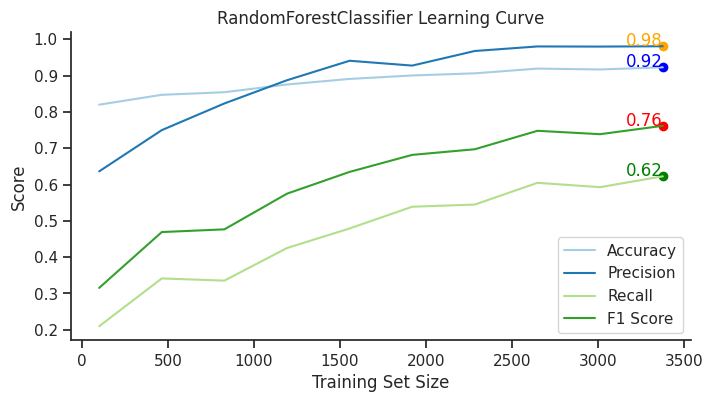

In [12]:
# Initial learning curve to diagnose the model
model = RandomForestClassifier()
plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages=10)

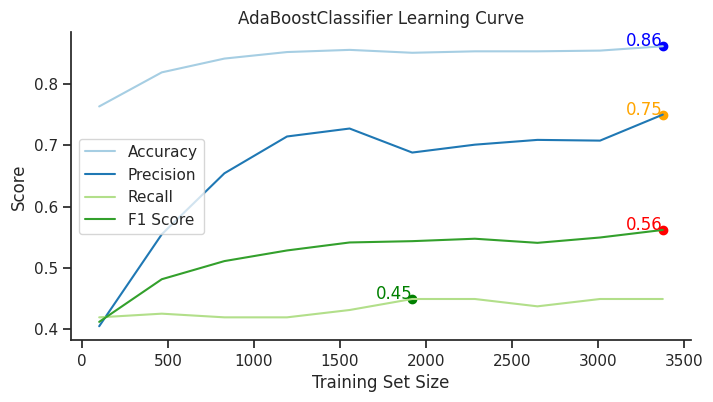

In [13]:
model = AdaBoostClassifier()
plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages=10)

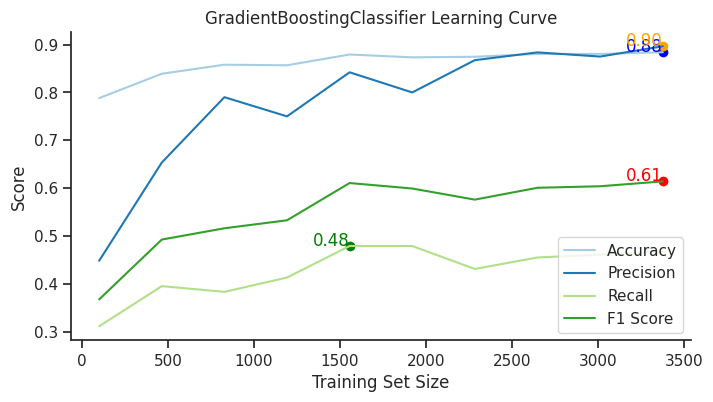

In [14]:
model = GradientBoostingClassifier()
plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages=10)

### 4.1.2. Non-linear Methods

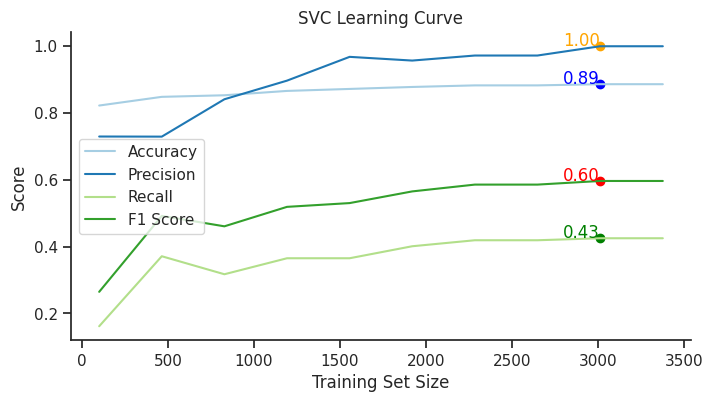

In [15]:
model = SVC()
plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages=10)

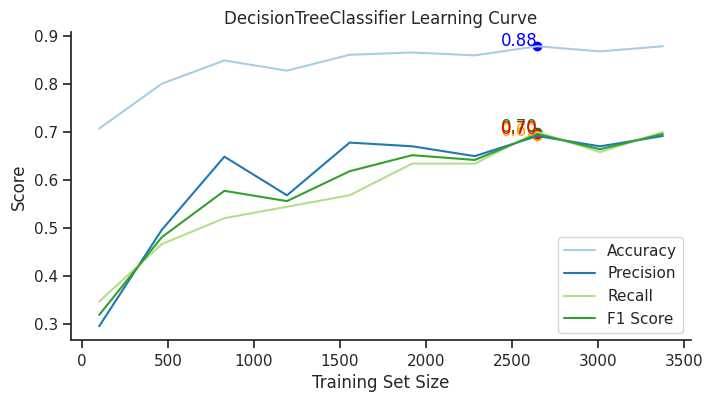

In [16]:
model = DecisionTreeClassifier()
plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages=10)

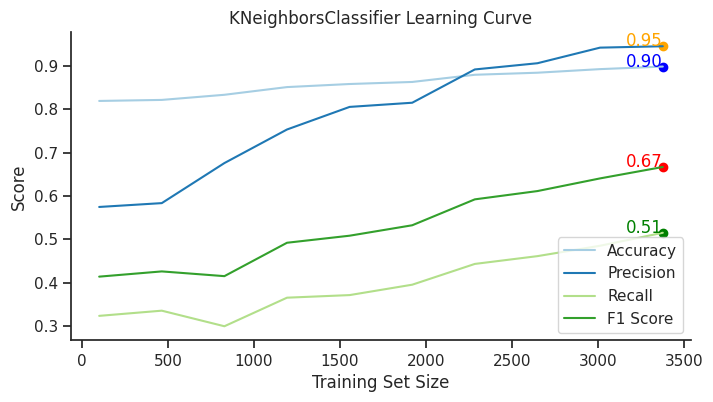

In [17]:
model = KNeighborsClassifier()
plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages=10)

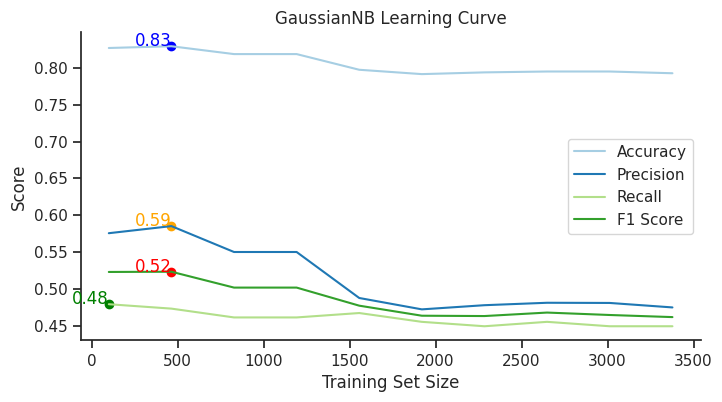

In [18]:
model = GaussianNB()
plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages=10)

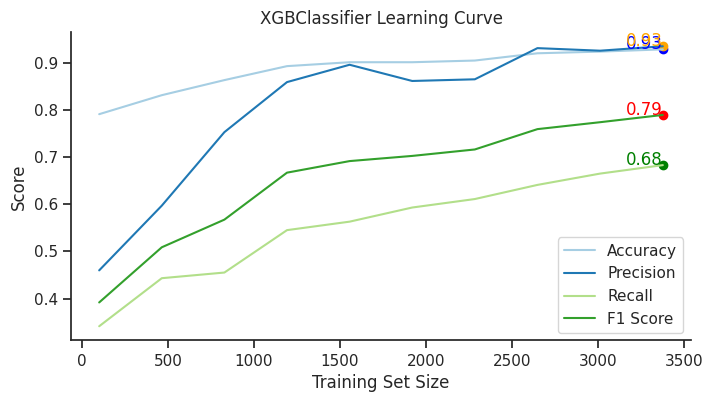

In [19]:
model = XGBClassifier()
plot_learning_curve(model, x_train, y_train, x_test, y_test, num_stages=10)

### 4.1.3. Linear Methods

#### 4.1.3.1. Check for Multicolinearity

We will use the Variance Inflation Factor (VIF), to check if there is multicollinearity in the data. Features having a VIF score > 5 will be dropped/treated till all the features have a VIF score < 5. The VIF for dummy variables can be ignored which is expected that they would have a high VIF. We don't expect this case we dropped the one of the dummy variables to prevent this result.

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [21]:
x = df[num_cols].copy()
vif_series = pd.Series(
    [variance_inflation_factor(x, i) for i in range(x.shape[1])],
    index = x.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

LOAN       4.983
MORTDUE   17.097
VALUE     22.057
YOJ        2.517
DEROG      1.171
DELINQ     1.209
CLAGE      5.499
NINQ       1.539
CLNO       6.666
dtype: float64



🔎 **Observations:** As we mentioned in the EDA Notebook, MORTDUE and VALUE has multicolinearity and should be removed. As well as CLNO.

In [23]:
x = df[num_cols].drop(['VALUE', 'CLNO'], axis=1).copy()
vif_series = pd.Series(
    [variance_inflation_factor(x, i) for i in range(x.shape[1])],
    index = x.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

LOAN      4.170
MORTDUE   4.076
YOJ       2.463
DEROG     1.157
DELINQ    1.176
CLAGE     4.385
NINQ      1.494
dtype: float64



In [33]:
new_num_cols = num_cols[:2] + num_cols[3:-1]
new_num_cols

['LOAN', 'MORTDUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ']

In [38]:
x_train, x_test, y_train, y_test = transform_data(df.drop(['VALUE', 'CLNO'], axis=1),
                                                  target, new_num_cols, cat_cols, 'ndnlno')

print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (3377, 13)
x_test: (845, 13)


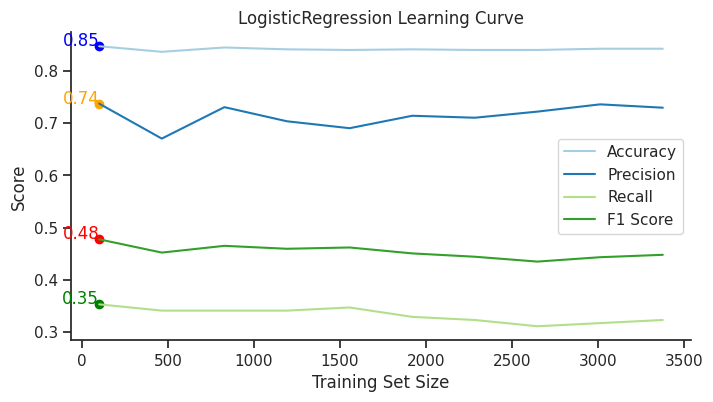

In [40]:
model = LogisticRegression()
plot_learning_curve(model, x_train, y_train, x_test, y_test, 10)

## 4.2. Hyperparamater Tuning

In [41]:
x_train, x_test, y_train, y_test = transform_data(df, target, num_cols,
                                                  cat_cols, 'ndnlno')

print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (3377, 15)
x_test: (845, 15)


In [42]:
model_dt = DecisionTreeClassifier()

crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

# Define the parameter grid to tune the hyperparameters
h_params = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(
    estimator = model_dt,
    param_grid = h_params,
    scoring = 'recall',
    n_jobs = -1,
    cv = crossvalidation
    )

grid.fit(x_train, y_train)

# Print the best score and the hyper parameters that provides that score
grid.best_params_, grid.best_score_

({'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2},
 0.6277858826169902)

In [43]:
model = DecisionTreeClassifier(**grid.best_params_)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=30)

In [44]:
y_hat = model.predict(x_test)

In [45]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       678
           1       0.75      0.66      0.70       167

    accuracy                           0.89       845
   macro avg       0.83      0.81      0.82       845
weighted avg       0.89      0.89      0.89       845



In [50]:
def plot_confusion_matrix(y_test, predictions):
    # Plot the confusion matrix
    cf_matrix = confusion_matrix(y_test, predictions)
    fig = plt.subplots(figsize=(10, 8))
    sb.set(font_scale=1.6)
    sb.heatmap(cf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

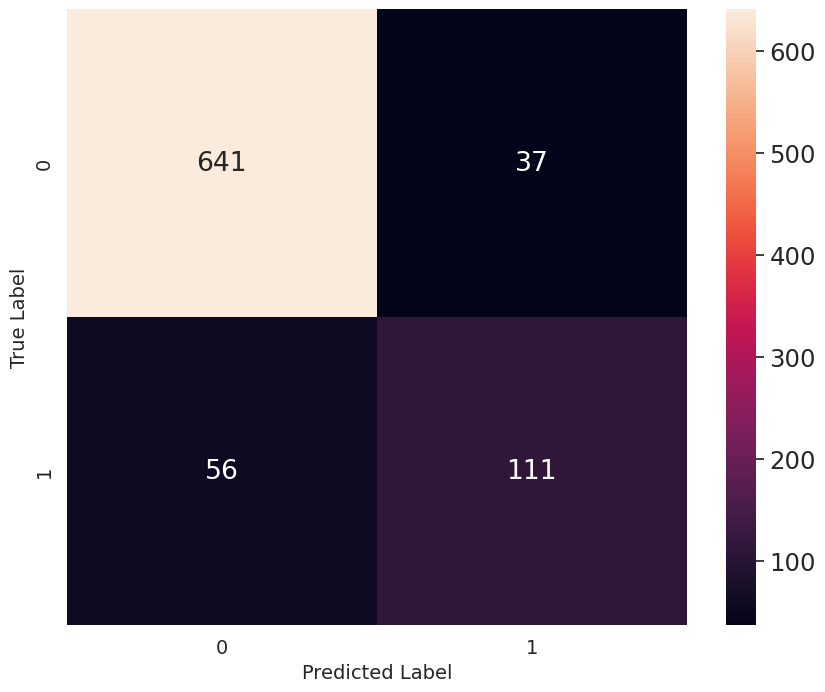

In [51]:
plot_confusion_matrix(y_test, y_hat)

In [52]:
def plot_roc_curve(y_test, predictions, estimator):
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=estimator)
    display.plot()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()

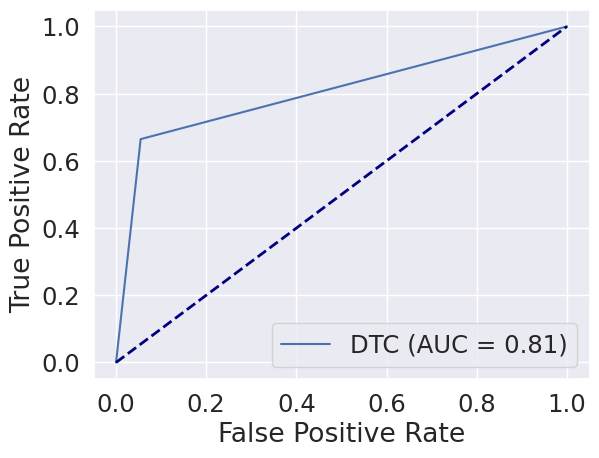

In [53]:
plot_roc_curve(y_test, y_hat, 'DTC')

In [54]:
with open('../Models/model_dtc.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

FileNotFoundError: [Errno 2] No such file or directory: '../Models/model_dtc.pkl'

In [55]:
!ls

Data  Images  License.md  Models  Notebooks  README.md
